In [34]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt

In [35]:
file_path = 'C:\\Users\\zoec0\\Desktop\\DSMP\\OneDrive_1_2024-2-8\\LOBs\\UoB_Set01_2025-04-08LOBs.txt'

In [36]:
# Parsing single-line text
def parse_line_corrected(line):
    line = line.replace('Exch0', "'Exch0'")
    data = ast.literal_eval(line)
    return {
        'timestamp': data[0],
        'exchange': data[1],
        'bids': data[2][0][1],
        'asks': data[2][1][1]
    }

In [37]:
# Parses incoming text line by line
parsed_data_corrected = []
with open(file_path, 'r') as file:
    for line in file:
        parsed_data_corrected.append(parse_line_corrected(line))

In [38]:
df_corrected = pd.DataFrame(parsed_data_corrected)

In [39]:
df_corrected = df_corrected[['exchange', 'timestamp', 'bids', 'asks']]
df_corrected.head()

,exchange,timestamp,bids,asks
0,Exch0,0.000,[],[]
1,Exch0,2.697,"[[146, 9]]",[]
2,Exch0,3.658,"[[147, 3], [146, 9]]",[]
3,Exch0,4.061,"[[147, 3], [146, 9]]","[[151, 5]]"
4,Exch0,4.185,"[[147, 3], [146, 9]]","[[151, 5], [474, 2]]"


In [40]:
# Sort bids and asks and take the top two
def process_row(row):
    bids_sorted = sorted(row['bids'], key=lambda x: x[0], reverse=True)[:2] if row['bids'] else []
    asks_sorted = sorted(row['asks'], key=lambda x: x[0])[:2] if row['asks'] else []
    return bids_sorted, asks_sorted

In [41]:
df_corrected[['bids', 'asks']] = df_corrected.apply(lambda row: process_row(row), axis=1, result_type='expand')
df_filtered = (df_corrected[(df_corrected['bids'].apply(len) >= 2) & (df_corrected['asks'].apply(len) >= 2)]).reset_index(drop=True)
df_filtered.head()

,exchange,timestamp,bids,asks
0,Exch0,4.185,"[[147, 3], [146, 9]]","[[151, 5], [474, 2]]"
1,Exch0,4.247,"[[147, 3], [146, 9]]","[[151, 4], [474, 2]]"
2,Exch0,4.278,"[[147, 3], [146, 9]]","[[151, 4], [156, 2]]"
3,Exch0,4.619,"[[147, 3], [146, 9]]","[[156, 2], [713, 4]]"
4,Exch0,4.774,"[[147, 3], [146, 9]]","[[156, 2], [187, 4]]"


In [42]:
def remove_max_bid_outliers(bids, mean_price, std_price, threshold=3):
    if not bids:
        return True  
    # Calculate z-score for the maximum bid price
    max_bid_price = max(bid[0] for bid in bids)
    z_score = abs(max_bid_price - mean_price) / std_price
    
    # Return True if the z-score is within the threshold, indicating it's not an outlier
    return z_score <= threshold

# Calculate the mean and standard deviation for the maximum bid prices
max_bid_prices = [max(bid[0] for bid in bids_list) for bids_list in df_filtered['bids'] if bids_list]
mean_max_price = np.mean(max_bid_prices)
std_max_price = np.std(max_bid_prices)

# Filter the DataFrame rows
df_filtered_no_max_outliers = df_filtered[df_filtered['bids'].apply(
    lambda bids: remove_max_bid_outliers(bids, mean_max_price, std_max_price, 3)
)]

# Reset the index after the filter operation
df_filtered_no_max_outliers = df_filtered_no_max_outliers.reset_index(drop=True)

df_filtered_no_max_outliers

,exchange,timestamp,bids,asks
0,Exch0,4.185,"[[147, 3], [146, 9]]","[[151, 5], [474, 2]]"
1,Exch0,4.247,"[[147, 3], [146, 9]]","[[151, 4], [474, 2]]"
2,Exch0,4.278,"[[147, 3], [146, 9]]","[[151, 4], [156, 2]]"
3,Exch0,4.619,"[[147, 3], [146, 9]]","[[156, 2], [713, 4]]"
4,Exch0,4.774,"[[147, 3], [146, 9]]","[[156, 2], [187, 4]]"
...,...,...,...,...
308588,Exch0,30599.480,"[[163, 2], [161, 7]]","[[182, 1], [253, 3]]"
308589,Exch0,30599.759,"[[163, 1], [161, 7]]","[[182, 1], [253, 3]]"
308590,Exch0,30599.852,"[[163, 1], [161, 7]]","[[182, 1], [278, 2]]"
308591,Exch0,30599.883,"[[163, 1], [161, 7]]","[[182, 1], [491, 2]]"


In [43]:
def remove_min_bid_outliers(bids, mean_min_price, std_min_price, threshold=3):
    if not bids:
        return True
    min_bid_price = min(bid[0] for bid in bids)
    z_score = (min_bid_price - mean_min_price) / std_min_price
    return abs(z_score) <= threshold

# Calculate mean and standard deviation for the minimum bid prices across the DataFrame
min_bid_prices = [min(bid[0] for bid in bids_list) for bids_list in df_filtered_no_max_outliers['bids'] if bids_list]
mean_min_price = np.mean(min_bid_prices)
std_min_price = np.std(min_bid_prices)

# Apply the outlier removal function to each row
df_filtered_no_min_outliers = df_filtered_no_max_outliers[df_filtered_no_max_outliers['bids'].apply(
    lambda bids: remove_min_bid_outliers(bids, mean_min_price, std_min_price, 3)
)]

# Reset index
df_filtered_no_min_outliers.reset_index(drop=True, inplace=True)

# Display the first few rows
df_filtered_no_min_outliers

,exchange,timestamp,bids,asks
0,Exch0,4.185,"[[147, 3], [146, 9]]","[[151, 5], [474, 2]]"
1,Exch0,4.247,"[[147, 3], [146, 9]]","[[151, 4], [474, 2]]"
2,Exch0,4.278,"[[147, 3], [146, 9]]","[[151, 4], [156, 2]]"
3,Exch0,4.619,"[[147, 3], [146, 9]]","[[156, 2], [713, 4]]"
4,Exch0,4.774,"[[147, 3], [146, 9]]","[[156, 2], [187, 4]]"
...,...,...,...,...
299348,Exch0,30599.480,"[[163, 2], [161, 7]]","[[182, 1], [253, 3]]"
299349,Exch0,30599.759,"[[163, 1], [161, 7]]","[[182, 1], [253, 3]]"
299350,Exch0,30599.852,"[[163, 1], [161, 7]]","[[182, 1], [278, 2]]"
299351,Exch0,30599.883,"[[163, 1], [161, 7]]","[[182, 1], [491, 2]]"


In [44]:
def remove_min_ask_outliers(asks, mean_price, std_price, threshold=3):
    if not asks:
        return True  # Keep rows with no asks as they're not outliers
    min_ask_price = min(ask[0] for ask in asks)
    z_score = (min_ask_price - mean_price) / std_price
    return abs(z_score) <= threshold

# Calculate mean and standard deviation for minimum ask prices
min_ask_prices = [min(ask[0] for ask in asks_list) for asks_list in df_filtered['asks'] if asks_list]
mean_min_ask_price = np.mean(min_ask_prices)
std_min_ask_price = np.std(min_ask_prices)

# Apply the function to filter rows based on minimum ask price outliers
df_filtered_no_min_ask_outliers = df_filtered_no_min_outliers[df_filtered_no_min_outliers['asks'].apply(
    lambda asks: remove_min_ask_outliers(asks, mean_min_ask_price, std_min_ask_price, 3)
)]

# Reset the index after filtering
df_filtered_no_min_ask_outliers.reset_index(drop=True, inplace=True)

df_filtered_no_min_ask_outliers

,exchange,timestamp,bids,asks
0,Exch0,4.185,"[[147, 3], [146, 9]]","[[151, 5], [474, 2]]"
1,Exch0,4.247,"[[147, 3], [146, 9]]","[[151, 4], [474, 2]]"
2,Exch0,4.278,"[[147, 3], [146, 9]]","[[151, 4], [156, 2]]"
3,Exch0,4.619,"[[147, 3], [146, 9]]","[[156, 2], [713, 4]]"
4,Exch0,4.774,"[[147, 3], [146, 9]]","[[156, 2], [187, 4]]"
...,...,...,...,...
291159,Exch0,30599.480,"[[163, 2], [161, 7]]","[[182, 1], [253, 3]]"
291160,Exch0,30599.759,"[[163, 1], [161, 7]]","[[182, 1], [253, 3]]"
291161,Exch0,30599.852,"[[163, 1], [161, 7]]","[[182, 1], [278, 2]]"
291162,Exch0,30599.883,"[[163, 1], [161, 7]]","[[182, 1], [491, 2]]"


In [45]:
def remove_max_ask_outlier(asks, mean_price, std_price, threshold=3):
    if not asks:
        return True
    max_ask_price = max(ask[0] for ask in asks)
    z_score = (max_ask_price - mean_price) / std_price
    return abs(z_score) <= threshold

# Calculate mean and standard deviation for maximum ask prices
max_ask_prices = [max(ask[0] for ask in asks_list) for asks_list in df_filtered_no_min_ask_outliers['asks'] if asks_list]
mean_max_ask_price = np.mean(max_ask_prices)
std_max_ask_price = np.std(max_ask_prices)

# Apply the function to filter rows based on maximum ask price outliers
df_filtered_no_max_ask_outliers = df_filtered_no_min_ask_outliers[df_filtered_no_min_ask_outliers['asks'].apply(
    lambda asks: remove_max_ask_outlier(asks, mean_max_ask_price, std_max_ask_price, 3)
)]

# Reset the index after filtering
df_filtered_no_max_ask_outliers.reset_index(drop=True, inplace=True)

df_filtered_no_max_ask_outliers

,exchange,timestamp,bids,asks
0,Exch0,4.185,"[[147, 3], [146, 9]]","[[151, 5], [474, 2]]"
1,Exch0,4.247,"[[147, 3], [146, 9]]","[[151, 4], [474, 2]]"
2,Exch0,4.278,"[[147, 3], [146, 9]]","[[151, 4], [156, 2]]"
3,Exch0,4.774,"[[147, 3], [146, 9]]","[[156, 2], [187, 4]]"
4,Exch0,5.642,"[[147, 3], [146, 9]]","[[187, 4], [306, 2]]"
...,...,...,...,...
286054,Exch0,30599.480,"[[163, 2], [161, 7]]","[[182, 1], [253, 3]]"
286055,Exch0,30599.759,"[[163, 1], [161, 7]]","[[182, 1], [253, 3]]"
286056,Exch0,30599.852,"[[163, 1], [161, 7]]","[[182, 1], [278, 2]]"
286057,Exch0,30599.883,"[[163, 1], [161, 7]]","[[182, 1], [491, 2]]"


In [46]:
def split_bids_asks(row):
    # Splitting bids into prices and sizes
    bid_price1, bid_size1 = row['bids'][0]
    bid_price2, bid_size2 = row['bids'][1]
    ask_price1, ask_size1 = row['asks'][0]
    ask_price2, ask_size2 = row['asks'][1]  
    return pd.Series([bid_price1, bid_price2, bid_size1, bid_size2, ask_price1, ask_price2, ask_size1, ask_size2])

# Apply the function to each row of the DataFrame and create new columns
df_final_filtered = df_filtered_no_max_ask_outliers.copy()
df_final_filtered[['bid_price1', 'bid_price2', 'bid_size1', 'bid_size2', 'ask_price1', 'ask_price2', 'ask_size1', 'ask_size2']] = df_final_filtered.apply(split_bids_asks, axis=1)
df_final_filtered.drop(['bids', 'asks'], axis=1, inplace=True)

# Display the first few rows of the DataFrame to verify the changes
df_final_filtered

,exchange,timestamp,bid_price1,bid_price2,bid_size1,bid_size2,ask_price1,ask_price2,ask_size1,ask_size2
0,Exch0,4.185,147,146,3,9,151,474,5,2
1,Exch0,4.247,147,146,3,9,151,474,4,2
2,Exch0,4.278,147,146,3,9,151,156,4,2
3,Exch0,4.774,147,146,3,9,156,187,2,4
4,Exch0,5.642,147,146,3,9,187,306,4,2
...,...,...,...,...,...,...,...,...,...,...
286054,Exch0,30599.480,163,161,2,7,182,253,1,3
286055,Exch0,30599.759,163,161,1,7,182,253,1,3
286056,Exch0,30599.852,163,161,1,7,182,278,1,2
286057,Exch0,30599.883,163,161,1,7,182,491,1,2


In [47]:
df_final_filtered.to_csv('df_final_filtered.csv', index=False)

In [48]:
df_final_filtered

,exchange,timestamp,bid_price1,bid_price2,bid_size1,bid_size2,ask_price1,ask_price2,ask_size1,ask_size2
0,Exch0,4.185,147,146,3,9,151,474,5,2
1,Exch0,4.247,147,146,3,9,151,474,4,2
2,Exch0,4.278,147,146,3,9,151,156,4,2
3,Exch0,4.774,147,146,3,9,156,187,2,4
4,Exch0,5.642,147,146,3,9,187,306,4,2
...,...,...,...,...,...,...,...,...,...,...
286054,Exch0,30599.480,163,161,2,7,182,253,1,3
286055,Exch0,30599.759,163,161,1,7,182,253,1,3
286056,Exch0,30599.852,163,161,1,7,182,278,1,2
286057,Exch0,30599.883,163,161,1,7,182,491,1,2


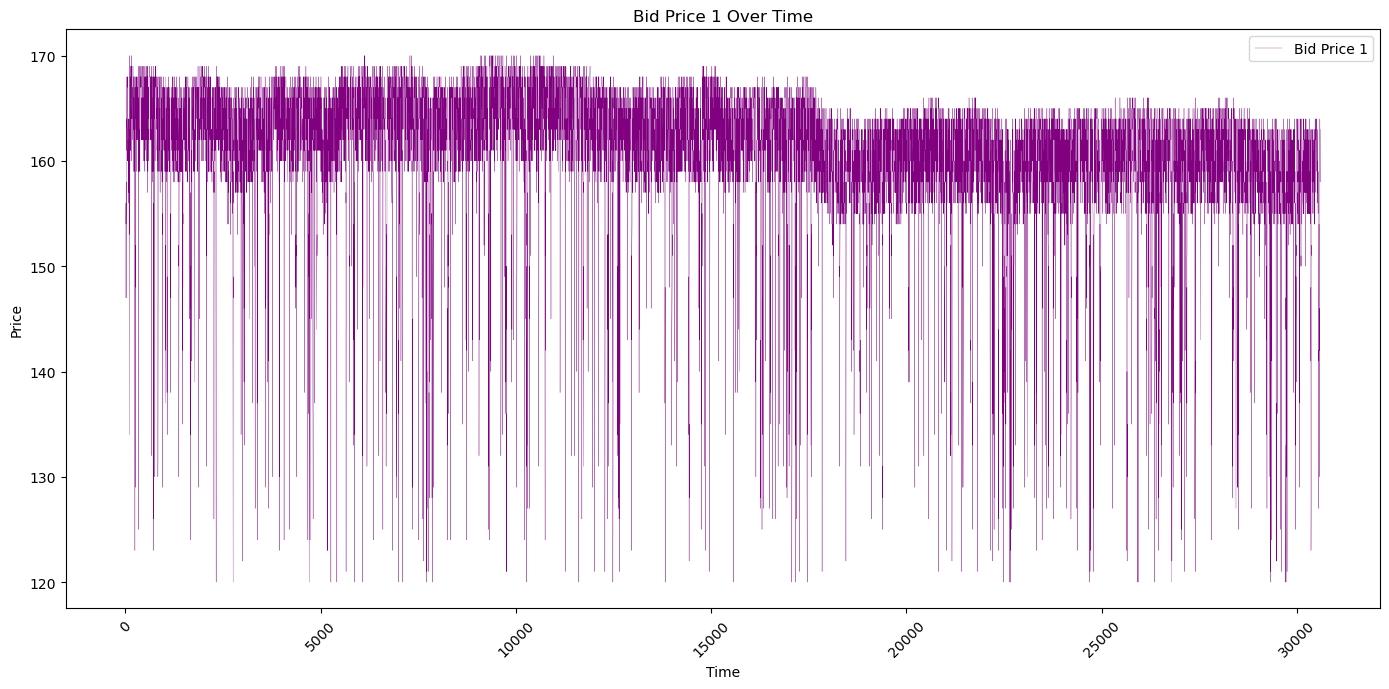

In [49]:
# Bid_price1 over Time

# Set the graphic size
plt.figure(figsize=(14, 7))

# Plot time series of best-buy prices
plt.plot(df_final_filtered['timestamp'], df_final_filtered['bid_price1'], label='Bid Price 1', color='purple', linewidth=0.2)

# Add some details on the graph
plt.title('Bid Price 1 Over Time')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels to improve visibility
plt.tight_layout()  # Automatically adjust sub-map parameters to fill the entire image area

# Display the graph
plt.show()

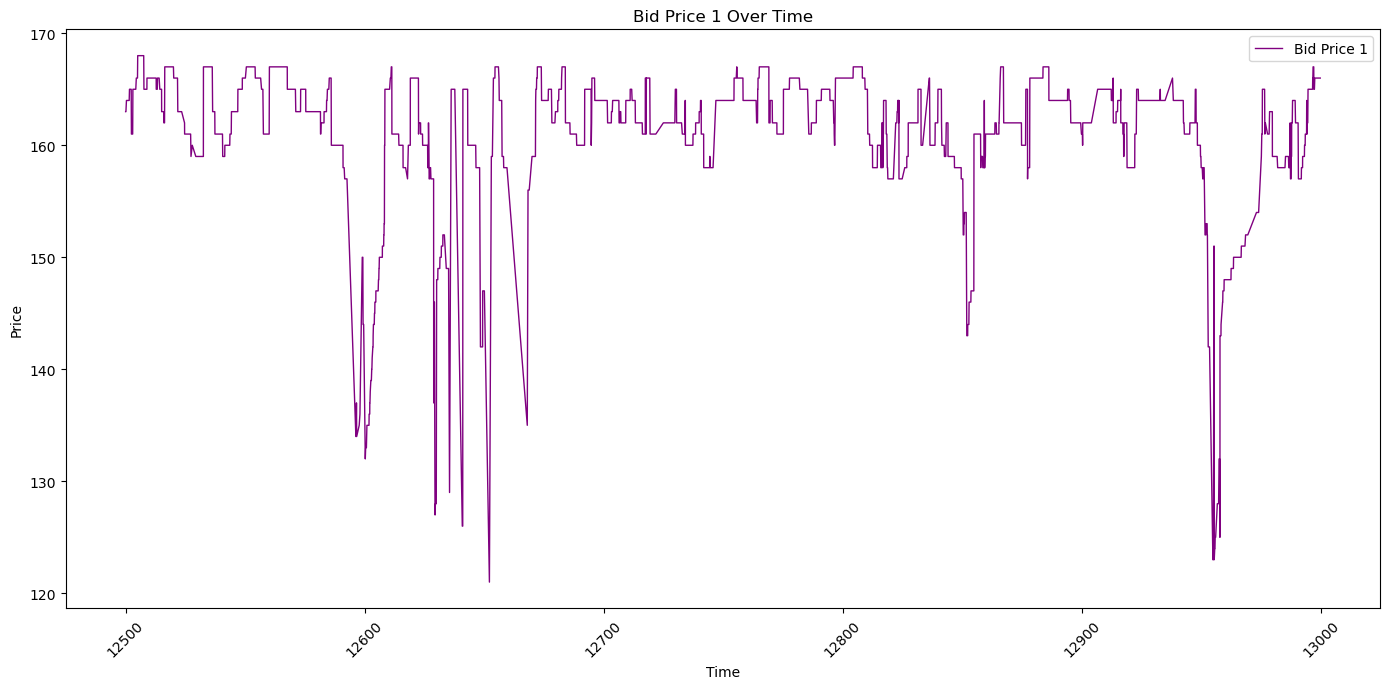

In [50]:
# Bid_price1 over Time

# Filtering data, timestamp between m and n
zoomin_filtered_df = df_final_filtered[(df_final_filtered['timestamp'] >= 12500) & (df_final_filtered['timestamp'] <= 13000)]

# Set the graphic size
plt.figure(figsize=(14, 7))

# Plot time series of best-buy prices
plt.plot(zoomin_filtered_df['timestamp'], zoomin_filtered_df['bid_price1'], label='Bid Price 1', color='purple', linewidth=1)

# Add some details on the graph
plt.title('Bid Price 1 Over Time')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels to improve visibility
plt.tight_layout()  # Automatically adjust sub-map parameters to fill the entire image area

# Display the graph
plt.show()


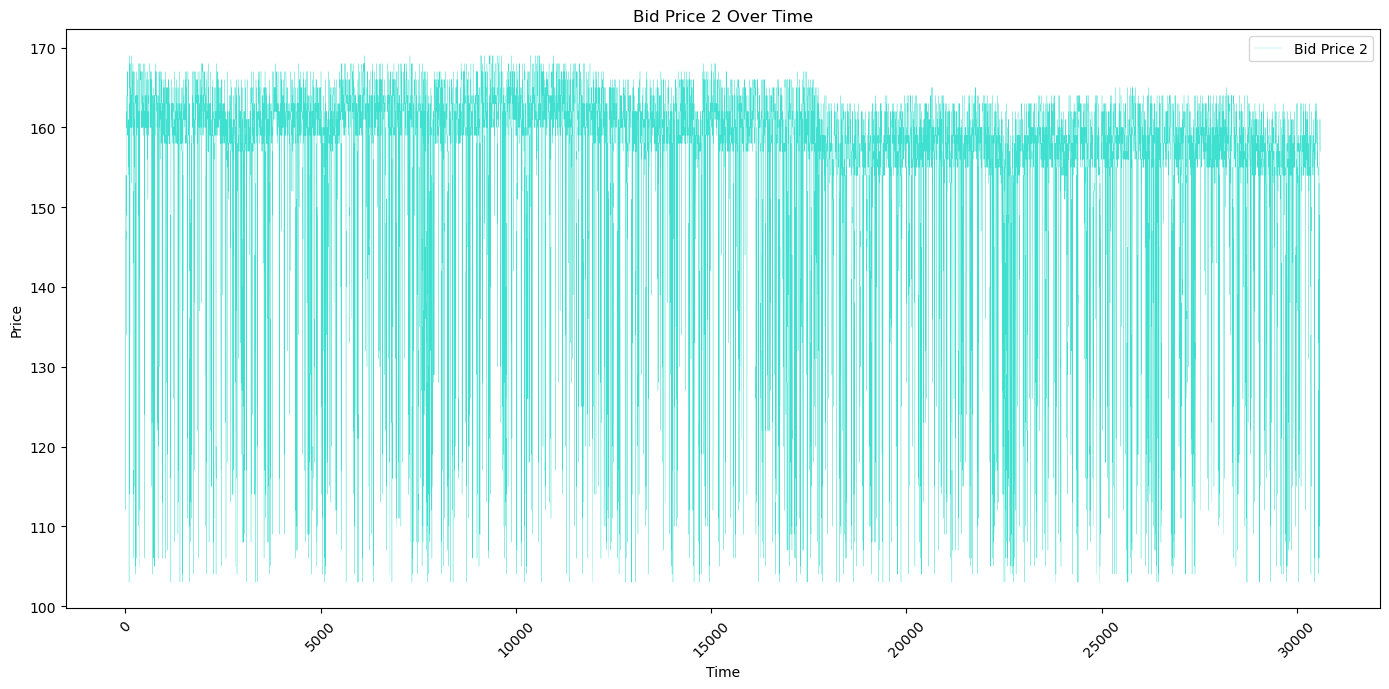

In [51]:
# Bid_price2 over Time

# Set the graphic size
plt.figure(figsize=(14, 7))

# Plot time series of best-buy prices
plt.plot(df_final_filtered['timestamp'], df_final_filtered['bid_price2'], label='Bid Price 2', color='turquoise', linewidth=0.2)

# Add some details on the graph
plt.title('Bid Price 2 Over Time')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels to improve visibility
plt.tight_layout()  # Automatically adjust sub-map parameters to fill the entire image area

# Display the graph
plt.show()

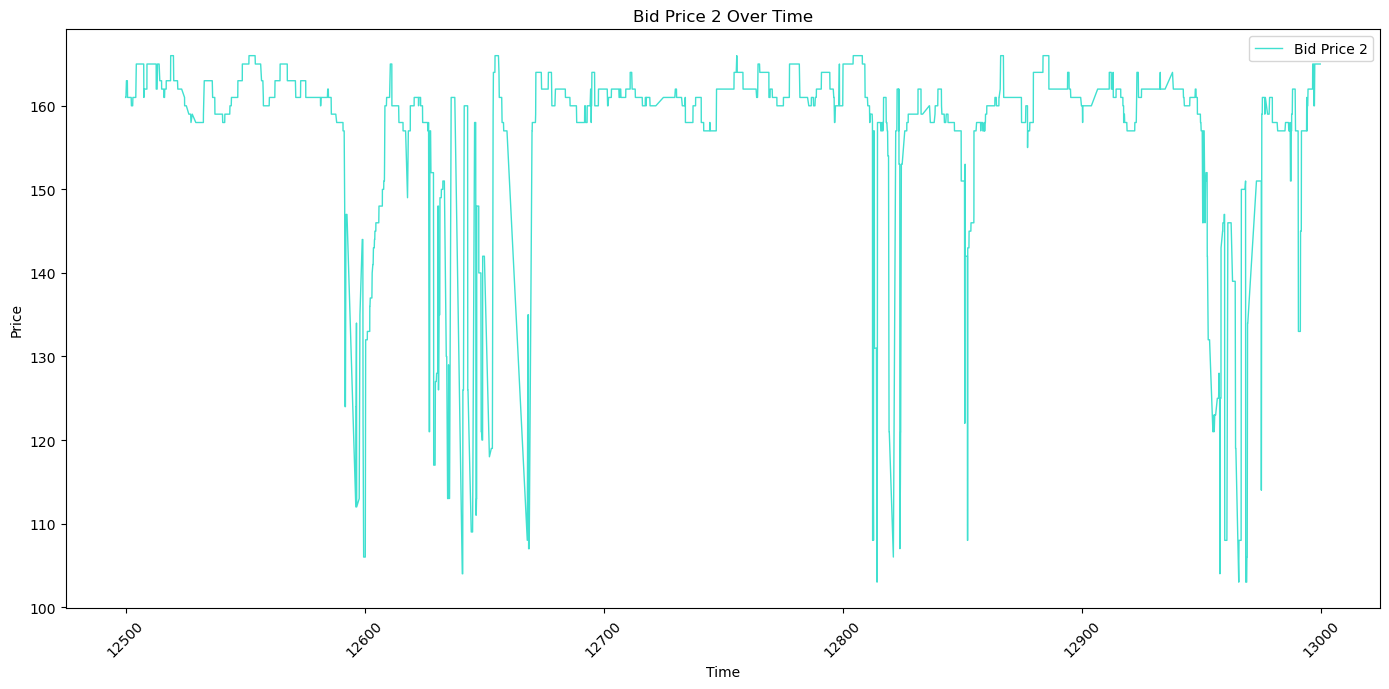

In [52]:
# Bid_price2 over Time

# Filtering data, timestamp between m and n
zoomin_filtered_df = df_final_filtered[(df_final_filtered['timestamp'] >= 12500) & (df_final_filtered['timestamp'] <= 13000)]

# Set the graphic size
plt.figure(figsize=(14, 7))

# Plot time series of best-buy prices
plt.plot(zoomin_filtered_df['timestamp'], zoomin_filtered_df['bid_price2'], label='Bid Price 2', color='turquoise', linewidth=1)

# Add some details on the graph
plt.title('Bid Price 2 Over Time')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels to improve visibility
plt.tight_layout()  # Automatically adjust sub-map parameters to fill the entire image area

# Display the graph
plt.show()


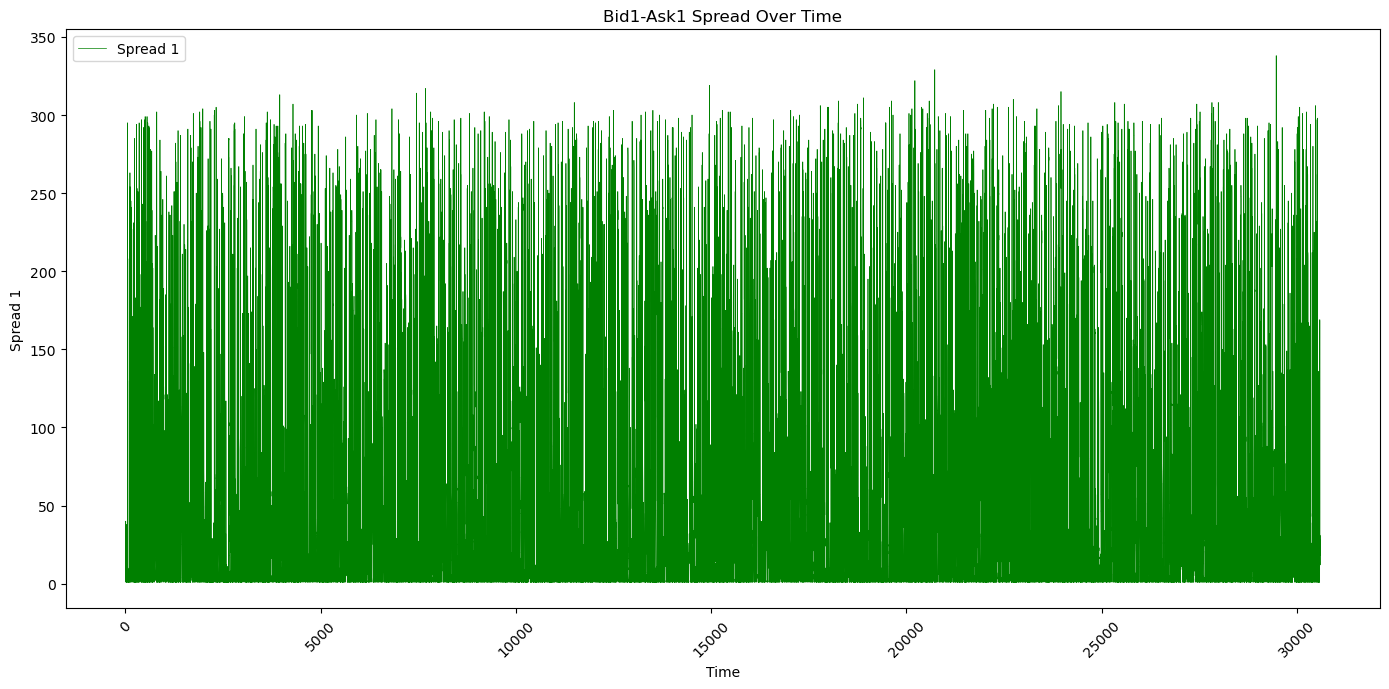

In [53]:
# spread1 = ask_price1 - bid_price1

# Calculate Spread1
df_final_filtered['spread1'] = df_final_filtered['ask_price1'] - df_final_filtered['bid_price1']

# Set the graphic size
plt.figure(figsize=(14, 7))

# Draw Spread1
plt.plot(df_final_filtered['timestamp'], df_final_filtered['spread1'], label='Spread 1', linewidth=0.5, color='green')

# Add some details on the graph
plt.title('Bid1-Ask1 Spread Over Time')
plt.xlabel('Time')
plt.ylabel('Spread 1')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels to improve visibility
plt.tight_layout()  # Automatically adjust sub-map parameters to fill the entire image area

# Display the graph
plt.show()

C:\Users\zoec0\AppData\Local\Temp\ipykernel_15180\135686089.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zoomin_filtered_df['spread1'] = zoomin_filtered_df['ask_price1'] - zoomin_filtered_df['bid_price1']


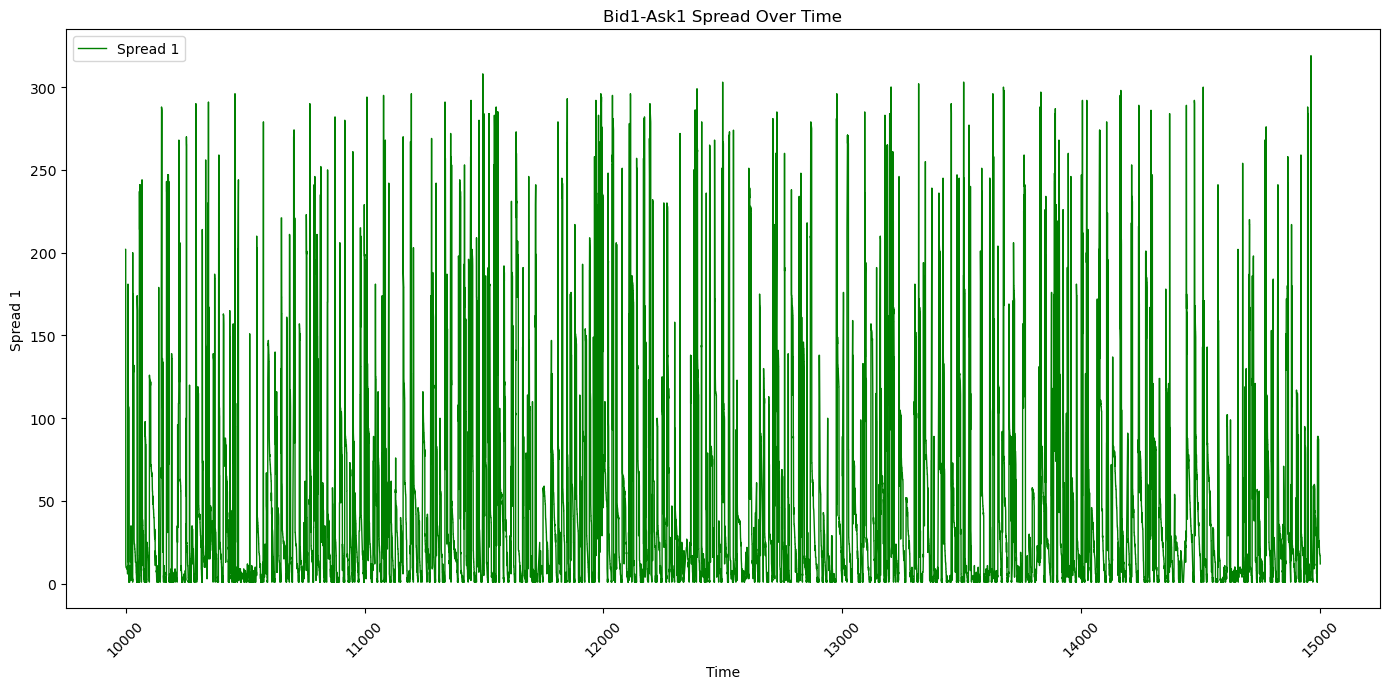

In [54]:
# spread1 = ask_price1 - bid_price1

# Filtering data, timestamp between m and n
zoomin_filtered_df = df_final_filtered[(df_final_filtered['timestamp'] >= 10000) & (df_final_filtered['timestamp'] <= 15000)]

# Calculate Spread1
zoomin_filtered_df['spread1'] = zoomin_filtered_df['ask_price1'] - zoomin_filtered_df['bid_price1']

# Set the graphic size
plt.figure(figsize=(14, 7))

# Draw Spread1
plt.plot(zoomin_filtered_df['timestamp'], zoomin_filtered_df['spread1'], label='Spread 1', linewidth=1, color='green')

# Add some details on the graph
plt.title('Bid1-Ask1 Spread Over Time')
plt.xlabel('Time')
plt.ylabel('Spread 1')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels to improve visibility
plt.tight_layout()  # Automatically adjust sub-map parameters to fill the entire image area

# Display the graph
plt.show()


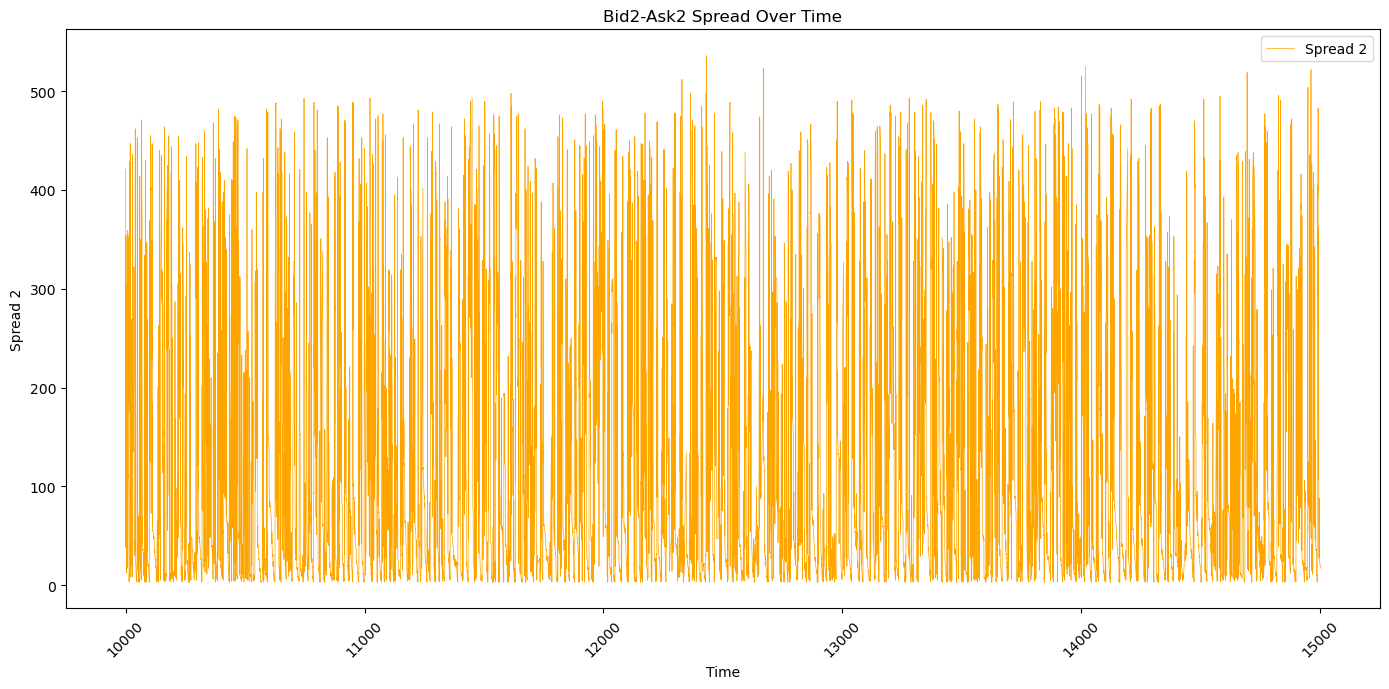

In [55]:
# spread2 = ask_price1=2 - bid_price2

# Calculate Spread2
df_final_filtered['spread2'] = df_final_filtered['ask_price2'] - zoomin_filtered_df['bid_price2']

# Set the graphic size
plt.figure(figsize=(14, 7))

# Draw Spread2
plt.plot(df_final_filtered['timestamp'], df_final_filtered['spread2'], label='Spread 2', linewidth=0.5, color='orange')

# Add some details on the graph
plt.title('Bid2-Ask2 Spread Over Time')
plt.xlabel('Time')
plt.ylabel('Spread 2')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels to improve visibility
plt.tight_layout()  # Automatically adjust sub-map parameters to fill the entire image area

# Display the graph
plt.show()

C:\Users\zoec0\AppData\Local\Temp\ipykernel_15180\997290921.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zoomin_filtered_df['spread2'] = zoomin_filtered_df['ask_price2'] - zoomin_filtered_df['bid_price2']


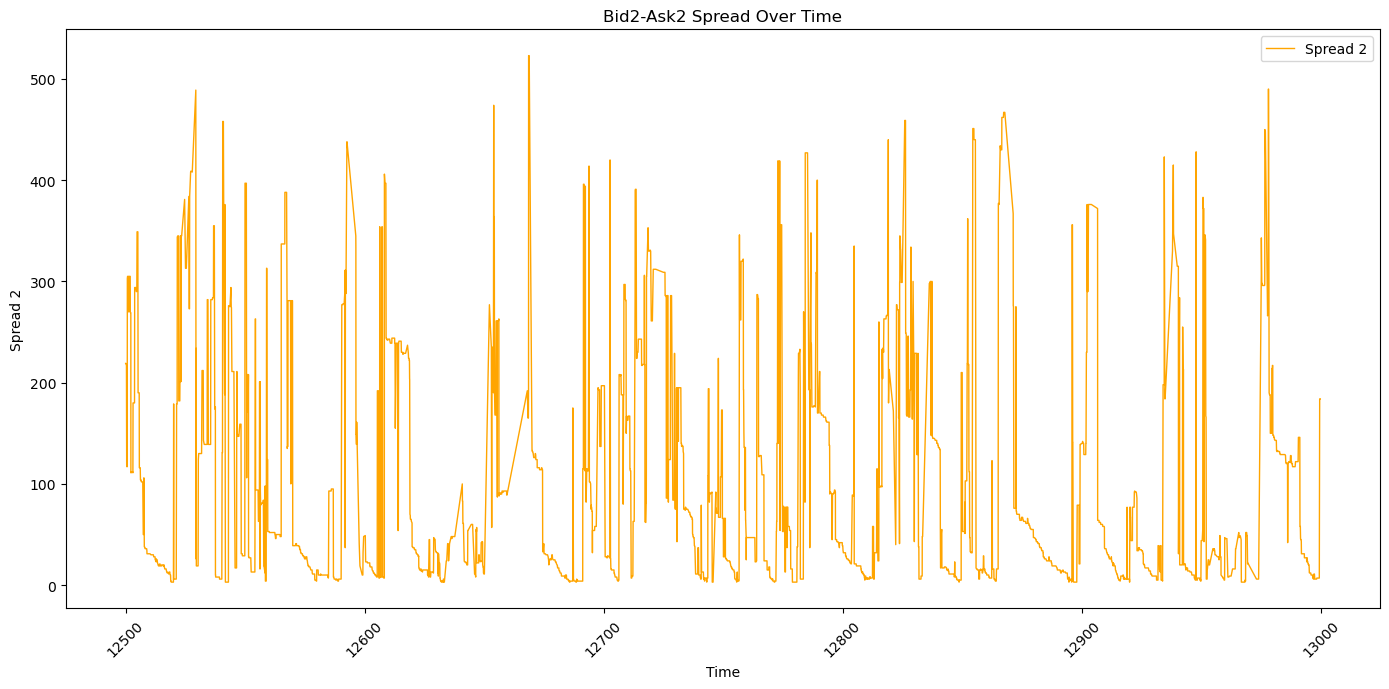

In [56]:
# spread2 = ask_price1=2 - bid_price2

# Filtering data, timestamp between m and n
zoomin_filtered_df = df_final_filtered[(df_final_filtered['timestamp'] >= 12500) & (df_final_filtered['timestamp'] <= 13000)]

# Calculate Spread2
zoomin_filtered_df['spread2'] = zoomin_filtered_df['ask_price2'] - zoomin_filtered_df['bid_price2']

# Set the graphic size
plt.figure(figsize=(14, 7))

# Draw Spread2
plt.plot(zoomin_filtered_df['timestamp'], zoomin_filtered_df['spread2'], label='Spread 2', linewidth=1, color='orange')

# Add some details on the graph
plt.title('Bid2-Ask2 Spread Over Time')
plt.xlabel('Time')
plt.ylabel('Spread 2')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels to improve visibility
plt.tight_layout()  # Automatically adjust sub-map parameters to fill the entire image area

# Display the graph
plt.show()


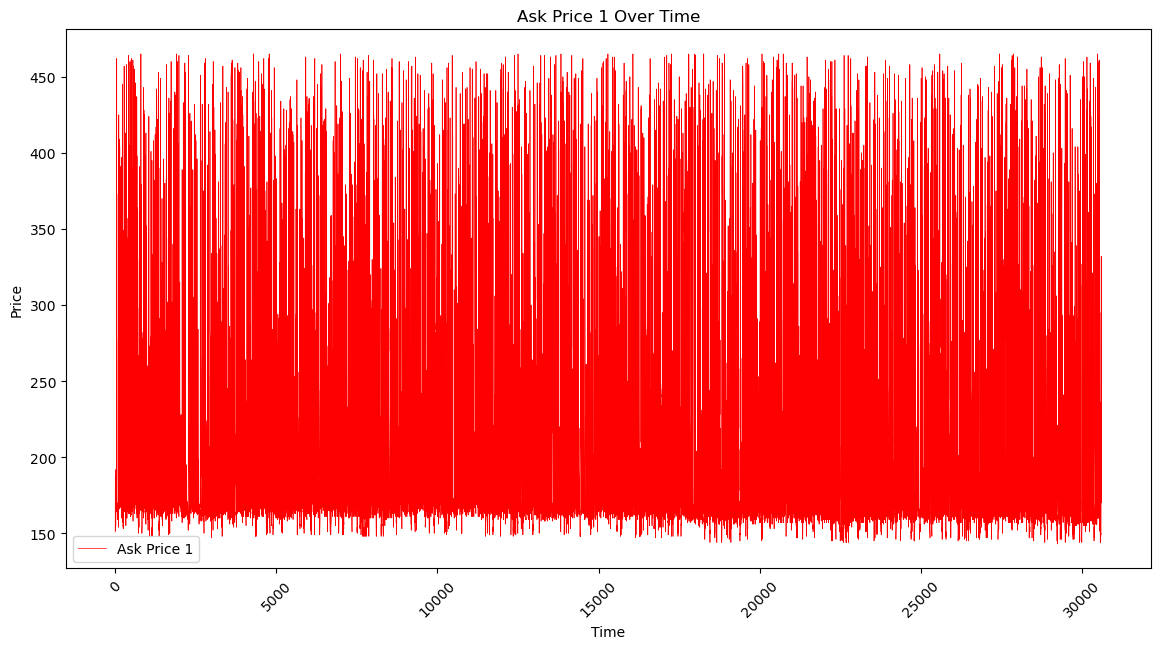

In [57]:
# Set the figure size for better visibility
plt.figure(figsize=(14, 7))

# Plot the best ask price over time
plt.plot(df_final_filtered['timestamp'], df_final_filtered['ask_price1'], label='Ask Price 1', color='red', linewidth=0.5)

# Beautify the plot with title, labels, and legend
plt.title('Ask Price 1 Over Time')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

# Show the plot
plt.show()

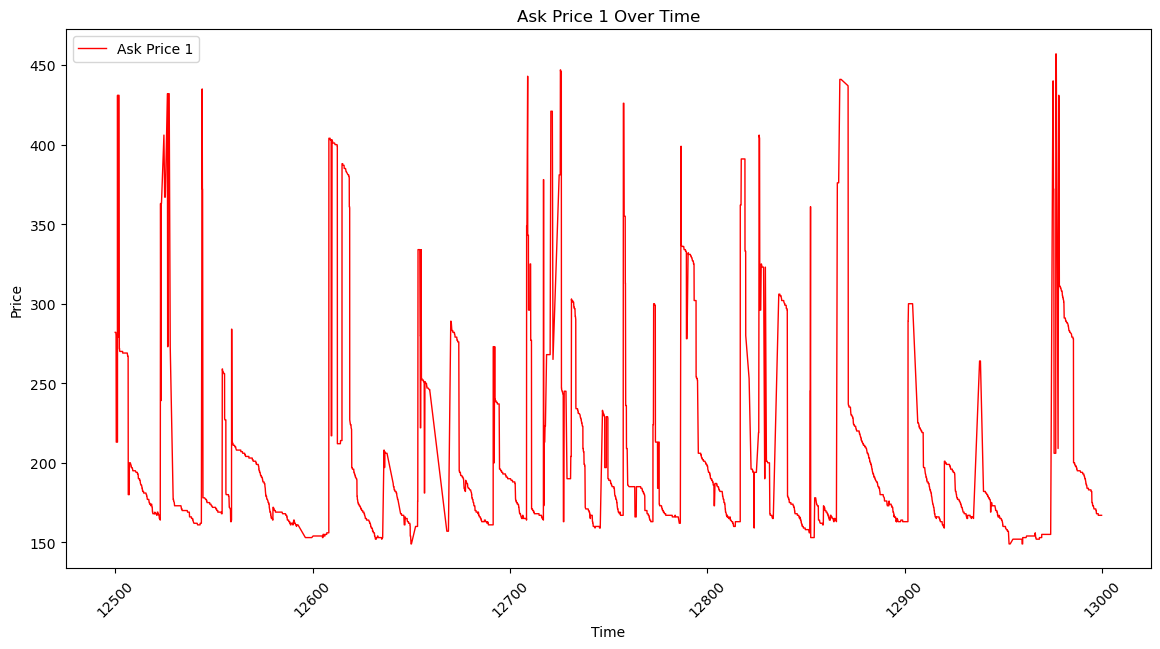

In [58]:
# Filtering data, timestamp between m and n
zoomin_filtered_df = df_final_filtered[(df_final_filtered['timestamp'] >= 12500) & (df_final_filtered['timestamp'] <= 13000)]

# Set the figure size for better visibility
plt.figure(figsize=(14, 7))

# Plot the best ask price over time
plt.plot(zoomin_filtered_df['timestamp'], zoomin_filtered_df['ask_price1'], label='Ask Price 1', color='red', linewidth=1)

# Beautify the plot with title, labels, and legend
plt.title('Ask Price 1 Over Time')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

# Show the plot
plt.show()


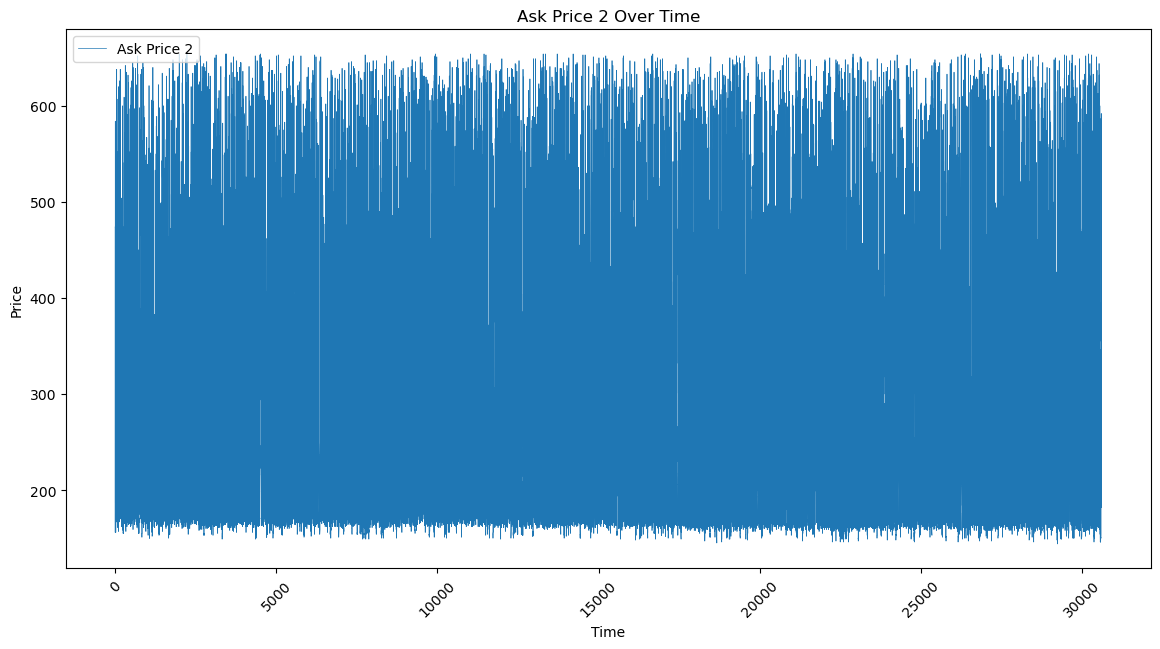

In [59]:
# Set the figure size for better visibility
plt.figure(figsize=(14, 7))

# Plot the best ask price over time
plt.plot(df_final_filtered['timestamp'], df_final_filtered['ask_price2'], label='Ask Price 2', linewidth=0.5)

# Beautify the plot with title, labels, and legend
plt.title('Ask Price 2 Over Time')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

# Show the plot
plt.show()


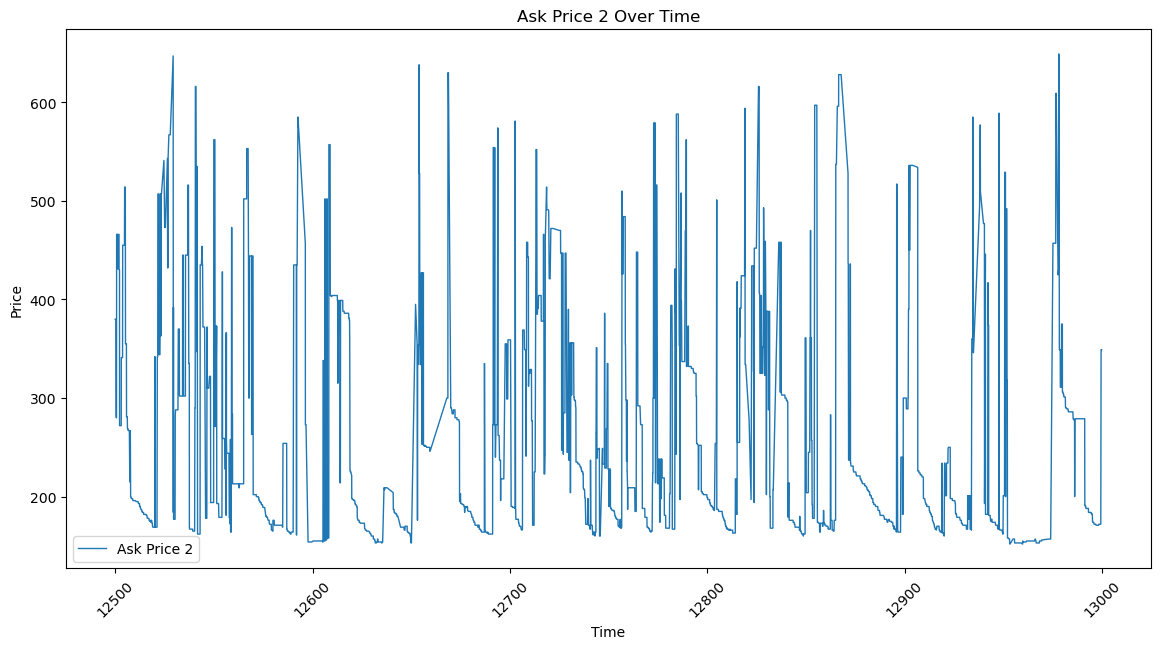

In [60]:
# Filtering data, timestamp between m and n
zoomin_filtered_df = df_final_filtered[(df_final_filtered['timestamp'] >= 12500) & (df_final_filtered['timestamp'] <= 13000)]

# Set the figure size for better visibility
plt.figure(figsize=(14, 7))

# Plot the best ask price over time
plt.plot(zoomin_filtered_df['timestamp'], zoomin_filtered_df['ask_price2'], label='Ask Price 2', linewidth=1)

# Beautify the plot with title, labels, and legend
plt.title('Ask Price 2 Over Time')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

# Show the plot
plt.show()


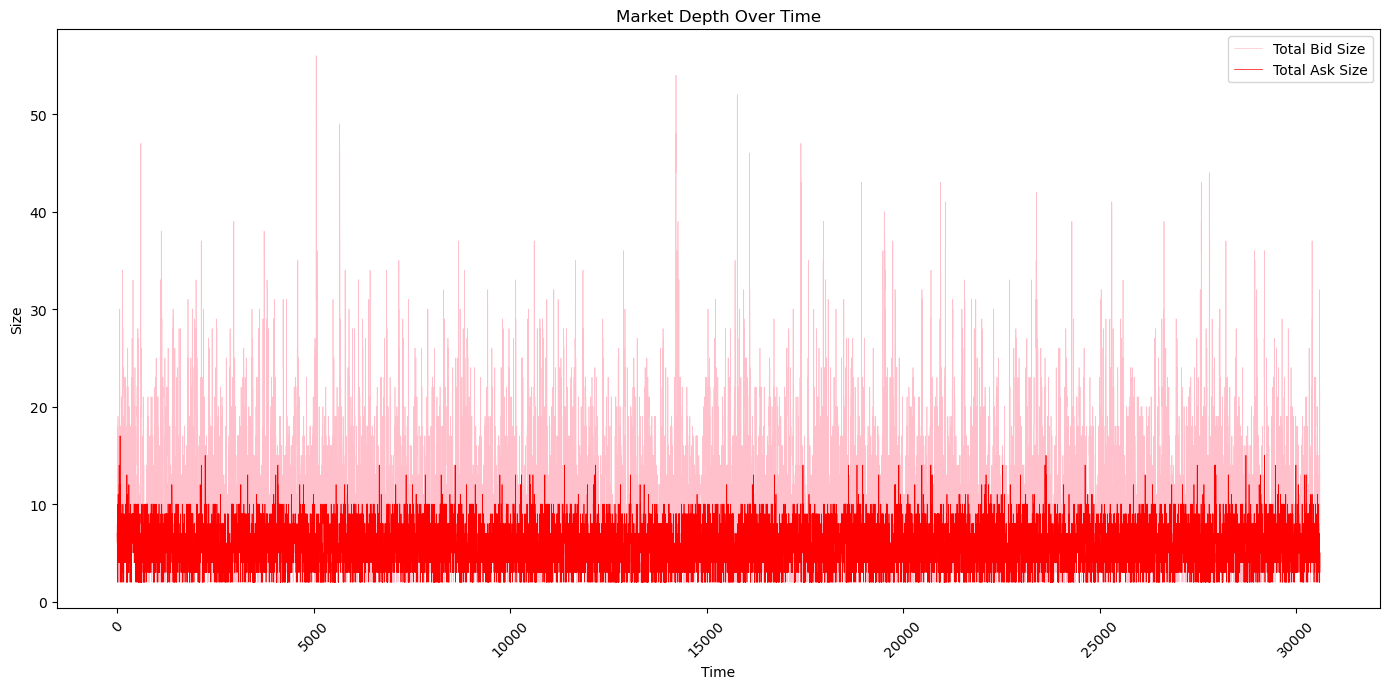

In [61]:
# Calculate total_bid_size and total_ask_size at each point in time
df_final_filtered['total_bid_size'] = df_final_filtered['bid_size1'] + df_final_filtered['bid_size2']
df_final_filtered['total_ask_size'] = df_final_filtered['ask_size1'] + df_final_filtered['ask_size2']

# Set the graphic size
plt.figure(figsize=(14, 7))

# Plot the change in market depth
plt.plot(df_final_filtered['timestamp'], df_final_filtered['total_bid_size'], label='Total Bid Size', linewidth=0.5, color='pink')
plt.plot(df_final_filtered['timestamp'], df_final_filtered['total_ask_size'], label='Total Ask Size', linewidth=0.5, color='red')

# Add some details on the graph
plt.title('Market Depth Over Time')
plt.xlabel('Time')
plt.ylabel('Size')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

C:\Users\zoec0\AppData\Local\Temp\ipykernel_15180\631702805.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zoomin_filtered_df['total_bid_size'] = zoomin_filtered_df['bid_size1'] + zoomin_filtered_df['bid_size2']
C:\Users\zoec0\AppData\Local\Temp\ipykernel_15180\631702805.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zoomin_filtered_df['total_ask_size'] = zoomin_filtered_df['ask_size1'] + zoomin_filtered_df['ask_size2']


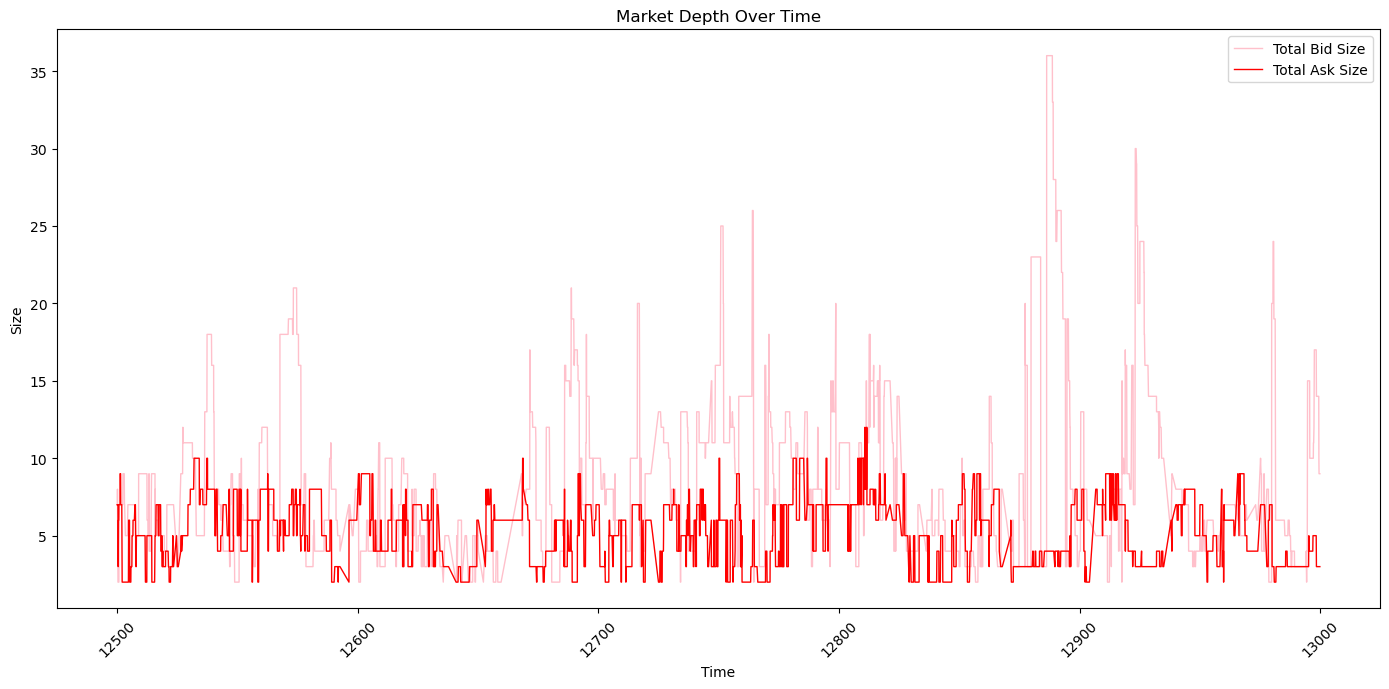

In [62]:
# Filtering data, timestamp between m and n
zoomin_filtered_df = df_final_filtered[(df_final_filtered['timestamp'] >= 12500) & (df_final_filtered['timestamp'] <= 13000)]

# Calculate total_bid_size and total_ask_size at each point in time
zoomin_filtered_df['total_bid_size'] = zoomin_filtered_df['bid_size1'] + zoomin_filtered_df['bid_size2']
zoomin_filtered_df['total_ask_size'] = zoomin_filtered_df['ask_size1'] + zoomin_filtered_df['ask_size2']

# Set the graphic size
plt.figure(figsize=(14, 7))

# Plot the change in market depth
plt.plot(zoomin_filtered_df['timestamp'], zoomin_filtered_df['total_bid_size'], label='Total Bid Size', linewidth=1, color='pink')
plt.plot(zoomin_filtered_df['timestamp'], zoomin_filtered_df['total_ask_size'], label='Total Ask Size', linewidth=1, color='red')

# Add some details on the graph
plt.title('Market Depth Over Time')
plt.xlabel('Time')
plt.ylabel('Size')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()
